In [1]:
import h5py
import os
import sys
import tensorflow as tf
import numpy as np
from bm3d import bm3d_rgb, BM3DProfile
module_dir = "/global/u2/k/kberard/SCGSR/Research/Diamond/stock_models/bm3d-4.0.3/bm3d-4.0.3/examples" 
sys.path.insert(0, module_dir)
from experiment_funcs import get_experiment_noise, get_psnr, get_cropped_psnr
from PIL import Image
import matplotlib.pyplot as plt


2025-08-01 06:15:27.439600: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754054127.617147 1455765 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754054127.663982 1455765 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754054128.034104 1455765 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754054128.034122 1455765 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754054128.034125 1455765 computation_placer.cc:177] computation placer alr

In [2]:
import math
import torch
import torch.nn as nn
import numpy as np
from thop import profile
from einops import rearrange 
from einops.layers.torch import Rearrange, Reduce
from timm.models.layers import trunc_normal_, DropPath

/global/u2/k/kberard/environments/SCGSR/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/global/u2/k/kberard/environments/SCGSR/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [3]:
print("here")

here


In [4]:
#image denoise methods to try
#arciteture only 2024 https://www.nature.com/articles/s41598-024-60139-x
# cascaded gaze 2019 https://github.com/Ascend-Research/CascadedGaze
# SwinIR 2021 https://github.com/JingyunLiang/SwinIR?tab=readme-ov-file
#scunet, ffdnet (compared in nature paper, very close to nat perf) or dnCNN  toolbox with many models https://github.com/cszn/KAIR
#scunet it python based 
# https://pypi.org/project/bm3d/ Bm3d also in nature paper

In [5]:
# minorized reference
with h5py.File('/global/u2/k/kberard/SCGSR/Research/Diamond/Data/density_tot_ref.h5', 'r') as file:
    #print("Keys: %s" % file.keys())
    ref_d = file['density'][:]
#print(ref_d)
print(ref_d.shape)




(64, 64, 64)


In [6]:
####################################################################################################################################################
def stochastic_density(d,N):
    # poisson model
    #  accurate and fast for all values of N
    # N  = number of MC samples
    assert isinstance(d,np.ndarray)
    assert isinstance(N,(int,float,np.int64,np.float64))
    assert N>0
    ds = np.random.poisson(N*d)/N
    ds*= d.sum()/ds.sum()
    return ds
#end def stochastic_density

####################################################################################################################################################

In [7]:
def generate_single_2d_density(ref_d, noise_level):
    noisy_3d = stochastic_density(ref_d, noise_level)  # shape: (64, 64, 64)
    return noisy_3d

# Noise levels to randomly draw from
noise_levels = [10000 * (j + 1) for j in range(5)]  # [10000, 20000, ..., 50000]

# Sizes
num_train = 5000
num_val = 1000
num_test = 500

# Generate train set with mixed noise levels
x_train = np.zeros((num_train, 64, 64,64))
for i in range(num_train):
    noise_level = np.random.choice(noise_levels)
    x_train[i] = generate_single_2d_density(ref_d, noise_level)

# Generate val set with mixed noise levels
x_val = np.zeros((num_val, 64, 64,64))
for i in range(num_val):
    noise_level = np.random.choice(noise_levels)
    x_val[i] = generate_single_2d_density(ref_d, noise_level)



print("Train, val, generated")


Train, val, generated


In [8]:
# Generate test set with fixed noise level
x_test = np.zeros((num_test, 64, 64, 64))
for i in range(num_test):
    x_test[i] = generate_single_2d_density(ref_d, 100000)
print("test generated")

test generated


In [9]:
print(ref_d.shape)

(64, 64, 64)


In [10]:
y_test_3d = np.zeros((x_test.shape[0],64,64,64))
y_train_3d = np.zeros((x_train.shape[0],64,64,64))
y_val_3d = np.zeros((x_val.shape[0],64,64,64))
for i in range (y_test_3d.shape[0]):
    y_test_3d[i]=stochastic_density(ref_d,1000000)
y_test = y_test_3d
for i in range (y_train_3d.shape[0]):
    y_train_3d[i]=stochastic_density(ref_d,1000000)
y_train = y_train_3d

for i in range (y_val_3d.shape[0]):
    y_val_3d[i]=stochastic_density(ref_d,1000000)
y_val = y_val_3d
print("here")

here


In [11]:
import numpy as np

def batch_project_3d_to_rgb(x_train_3d, x_val_3d, x_test_3d,
                            y_train_3d, y_val_3d, y_test_3d,
                            ref_d=None, buffer_scale=1.01):
    """
    Projects all input and output 3D densities to 2D RGB with per-sample normalization.
    Optionally includes a single reference density `ref_d`.

    Args:
        x_train_3d, x_val_3d, x_test_3d, y_train_3d, y_val_3d, y_test_3d: ndarray of shape (N, H, W, D)
        ref_d: ndarray of shape (H, W, D), optional reference sample
        buffer_scale: float, buffer for normalization (default 1.01)

    Returns:
        Tuple of normalized RGB arrays in order:
        x_train_rgb, x_val_rgb, x_test_rgb,
        y_train_rgb, y_val_rgb, y_test_rgb,
        ref_d_rgb (or None if not provided)
    """
    def split_sum_rgb(x_3d):
        N, H, W, D = x_3d.shape
        thirds = np.array_split(np.arange(D), 3)
        r = np.sum(x_3d[:, :, :, thirds[0]], axis=-1)
        g = np.sum(x_3d[:, :, :, thirds[1]], axis=-1)
        b = np.sum(x_3d[:, :, :, thirds[2]], axis=-1)
        return np.stack([r, g, b], axis=-1)

    def normalize_per_sample(x_rgb):
        max_vals = np.max(x_rgb, axis=(1, 2, 3), keepdims=True)
        max_vals = np.where(max_vals == 0, 1.0, max_vals)  # Prevent div by zero
        return np.clip(x_rgb / (max_vals * buffer_scale), 0, 1)

    def single_project_3d_to_rgb(x_3d_single):
        thirds = np.array_split(np.arange(x_3d_single.shape[-1]), 3)
        r = np.sum(x_3d_single[:, :, thirds[0]], axis=-1)
        g = np.sum(x_3d_single[:, :, thirds[1]], axis=-1)
        b = np.sum(x_3d_single[:, :, thirds[2]], axis=-1)
        rgb = np.stack([r, g, b], axis=-1)
        max_val = np.max(rgb)
        return np.clip(rgb / (max_val * buffer_scale if max_val > 0 else 1.0), 0, 1)

    # Convert to RGB
    x_train_rgb = normalize_per_sample(split_sum_rgb(x_train_3d))
    x_val_rgb   = normalize_per_sample(split_sum_rgb(x_val_3d))
    x_test_rgb  = normalize_per_sample(split_sum_rgb(x_test_3d))
    y_train_rgb = normalize_per_sample(split_sum_rgb(y_train_3d))
    y_val_rgb   = normalize_per_sample(split_sum_rgb(y_val_3d))
    y_test_rgb  = normalize_per_sample(split_sum_rgb(y_test_3d))

    # Optional: process ref_d
    ref_d_rgb = single_project_3d_to_rgb(ref_d) if ref_d is not None else None

    return (
        x_train_rgb, x_val_rgb, x_test_rgb,
        y_train_rgb, y_val_rgb, y_test_rgb,
        ref_d_rgb
    )


In [12]:
x_train_rgb, x_val_rgb, x_test_rgb, \
y_train_rgb, y_val_rgb, y_test_rgb, \
ref_d_rgb = batch_project_3d_to_rgb(
    x_train, x_val, x_test,
    y_train_3d, y_val_3d, y_test_3d,
    ref_d=ref_d,  # <== pass your (H, W, D) ref sample here
    buffer_scale=1.0
)
print("done generating")

done generating


In [1]:
"""import os
save_path = '/pscratch/sd/k/kberard/SCGSR/Data/gen_dat'
np.save(os.path.join(save_path, 'x_train_rgb.npy'), x_train_rgb)
np.save(os.path.join(save_path, 'x_val_rgb.npy'), x_val_rgb)
np.save(os.path.join(save_path, 'x_test_rgb.npy'), x_test_rgb)
np.save(os.path.join(save_path, 'y_train_rgb.npy'), y_train_rgb)
np.save(os.path.join(save_path, 'y_val_rgb.npy'), y_val_rgb)
np.save(os.path.join(save_path, 'y_test_rgb.npy'), y_test_rgb)
np.save(os.path.join(save_path, 'ref_d_rgb.npy'), ref_d_rgb)"""
import numpy as np

base_path = '/pscratch/sd/k/kberard/SCGSR/Data/gen_dat'

x_train_rgb = np.load(f'{base_path}/x_train_rgb.npy')
x_val_rgb   = np.load(f'{base_path}/x_val_rgb.npy')
x_test_rgb  = np.load(f'{base_path}/x_test_rgb.npy')
y_train_rgb = np.load(f'{base_path}/y_train_rgb.npy')
y_val_rgb   = np.load(f'{base_path}/y_val_rgb.npy')
y_test_rgb  = np.load(f'{base_path}/y_test_rgb.npy')
ref_d_rgb   = np.load(f'{base_path}/ref_d_rgb.npy')
print("done")

done


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models

# --- DenseNet blocks ---

def conv_block(x, growth_rate=12):
    x1 = layers.BatchNormalization()(x)
    x1 = layers.Conv2D(48, (1, 1), padding='same', activation='relu')(x1)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Conv2D(growth_rate, (3, 3), padding='same', activation='relu')(x1)
    return layers.Concatenate()([x, x1])

def dense_block(x, num_layers=4, growth_rate=12):
    for _ in range(num_layers):
        x = conv_block(x, growth_rate)
    return x

def transition_layer(x, out_channels=24):
    return layers.Conv2D(out_channels, (1, 1), padding='same')(x)

# --- Fusion block ---
# 👇 Define a serializable custom layer for tf.ones_like
@tf.keras.utils.register_keras_serializable()
class OnesLikeLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.ones_like(inputs)

def caffm(alpha, x, y):
    one_tensor = OnesLikeLayer()(alpha)
    inverse_alpha = layers.Subtract()([one_tensor, alpha])
    
    weighted_x = layers.Multiply()([alpha, x])
    weighted_y = layers.Multiply()([inverse_alpha, y])
    
    return layers.Add()([weighted_x, weighted_y])


# --- Model definition ---

def build_denoising_model(input_shape=(64, 64, 3)):
    inputs = layers.Input(shape=input_shape)
    
    # Initial conv
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(24, (3, 3), padding='same', activation='relu')(x)

    # Dense blocks + transitions
    db1 = dense_block(x)
    tr1 = transition_layer(db1)

    db2 = dense_block(tr1)
    tr2 = transition_layer(db2)

    db3 = dense_block(tr2)

    # Learnable fusion weight
    alpha = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(db3)
    
    # Expand alpha to matc
    
    alpha = layers.Concatenate()([alpha]*db1.shape[-1])

    fused = caffm(alpha, db1, db3)

    # Final residual connection
    output = layers.Conv2D(3, (3, 3), padding='same')(fused)
    residual_output = layers.Subtract()([inputs, output])

    return models.Model(inputs, residual_output)


2025-08-01 06:54:47.329205: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754056487.343165 1550653 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754056487.347423 1550653 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754056487.359662 1550653 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754056487.359674 1550653 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754056487.359675 1550653 computation_placer.cc:177] computation placer alr

In [3]:
# Build model
model = build_denoising_model()
model.compile(optimizer='adam', loss='mse')

# Train the model on your data
model.fit(x_train_rgb, y_train_rgb,
          validation_data=(x_val_rgb, y_val_rgb),
          batch_size=32,
          epochs=50)

# Evaluate on test set
model.evaluate(x_test_rgb, y_test_rgb)

# Predict denoised outputs
denoised_images = model.predict(x_test_rgb)


I0000 00:00:1754056502.655363 1550653 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37088 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0
I0000 00:00:1754056502.658353 1550653 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 37946 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
I0000 00:00:1754056502.661010 1550653 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 37946 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:82:00.0, compute capability: 8.0
I0000 00:00:1754056502.662595 1550653 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 37946 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:c1:00.0, compute capability: 8.0


Epoch 1/50


I0000 00:00:1754056512.750731 1551082 service.cc:152] XLA service 0x7f931c01c8e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754056512.750764 1551082 service.cc:160]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
I0000 00:00:1754056512.750774 1551082 service.cc:160]   StreamExecutor device (1): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
I0000 00:00:1754056512.750776 1551082 service.cc:160]   StreamExecutor device (2): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
I0000 00:00:1754056512.750778 1551082 service.cc:160]   StreamExecutor device (3): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-08-01 06:55:13.025256: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754056514.608230 1551082 cuda_dnn.cc:529] Loaded cuDNN version 90300


  7/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.7091  

I0000 00:00:1754056521.738563 1551082 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


157/157 ━━━━━━━━━━━━━━━━━━━━ 31s 87ms/step - loss: 0.1310 - val_loss: 0.0179
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0052 - val_loss: 0.0138
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0036 - val_loss: 0.0077
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0025 - val_loss: 0.0034
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 8/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 9/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 10/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 11/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 12/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/st

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


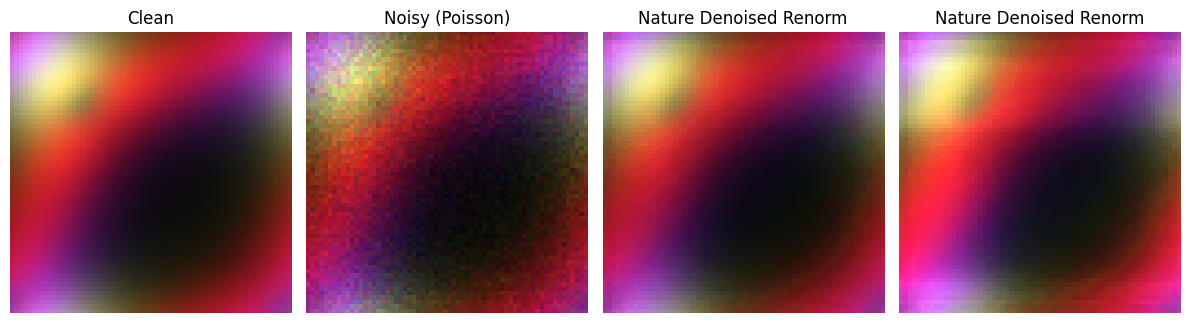

In [16]:
import matplotlib.pyplot as plt
x_denoised = model.predict(x_test_rgb[0:1])[0]  # Add batch, then squeeze
x_noisy = x_test_rgb[0]
x_clean = y_test_rgb[0]

# --- Plot ---
fig, axs = plt.subplots(1, 4, figsize=(12, 4))
axs[0].imshow(ref_d_rgb)
axs[0].set_title("Clean")
axs[0].axis("off")

axs[1].imshow(x_noisy)
axs[1].set_title("Noisy (Poisson)")
axs[1].axis("off")


axs[2].imshow(x_denoised)
axs[2].set_title("Nature Denoised Renorm")
axs[2].axis("off")

def normalize_per_sample(x_rgb):
        max_vals = np.max(x_rgb, axis=(1, 2), keepdims=True)
        max_vals = np.where(max_vals == 0, 1.0, max_vals)  # Prevent div by zero
        return np.clip(x_rgb / (max_vals * 1), 0, 1)

#might need to be renormalized because max is no longer 1
renorm_den = normalize_per_sample(x_denoised)
axs[3].imshow(renorm_den)
axs[3].set_title("Nature Denoised Renorm")
axs[3].axis("off")

plt.tight_layout()
plt.show()


In [17]:
print("Pixel sample (0,0):")
print("  Clean      :", x_clean[0,0])
print("  Noisy      :", x_noisy[0,0])
print("  Denoised   :", x_denoised[0,0])
print("  Renormed   :", renorm_den[0,0])

for label, img in zip(["Clean", "Noisy", "Denoised", "Renormed"],
                      [x_clean, x_noisy, np.clip(x_denoised, 0, 1), renorm_den]):
    print(f"{label:<10} max: {np.max(img):.4f}, sum: {np.sum(img):.2f}")


Pixel sample (0,0):
  Clean      : [0.65584416 0.28153989 0.62755102]
  Noisy      : [0.57983193 0.25210084 0.59663866]
  Denoised   : [0.69983387 0.2792588  0.6974822 ]
  Renormed   : [0.72560704 0.2895432  0.7231688 ]
Clean      max: 1.0000, sum: 3708.82
Noisy      max: 1.0000, sum: 3354.80
Denoised   max: 0.9835, sum: 3734.48
Renormed   max: 1.0000, sum: 4381.06


In [18]:
def jensen_shannon_divergence_loss(y_true, y_pred):
    y_t = tf.cast(y_true, tf.float32)
    y_p = tf.cast(y_pred, tf.float32)

    y_t = tf.reshape(y_t, [tf.shape(y_t)[0], -1])
    y_p = tf.reshape(y_p, [tf.shape(y_p)[0], -1])

    y_t /= tf.reduce_sum(y_t, axis=1, keepdims=True) + 1e-8
    y_p /= tf.reduce_sum(y_p, axis=1, keepdims=True) + 1e-8

    m = 0.5 * (y_t + y_p)

    kl_true = tf.reduce_sum(y_t * tf.math.log((y_t + 1e-8) / (m + 1e-8)), axis=1)
    kl_pred = tf.reduce_sum(y_p * tf.math.log((y_p + 1e-8) / (m + 1e-8)), axis=1)

    jsd = 0.5 * (kl_true + kl_pred)

    return tf.reduce_mean(jsd)

In [19]:
# --- Evaluation ---
print("\n>>> Evaluation Metrics on BM3D Denoised Image")

# 2-norm difference (before/after renorm)
norm_original = np.linalg.norm(x_denoised - x_clean)
norm_renormed = np.linalg.norm(renorm_den - x_clean)

print(f"2-norm (x_denoised vs ref_d_rgb): {norm_original:.4f}")
print(f"2-norm (renormalized vs ref_d_rgb): {norm_renormed:.4f}")

# Jensen-Shannon divergence setup
import tensorflow as tf
from tensorflow.keras.losses import KLDivergence

jsd_noisy = jensen_shannon_divergence_loss(tf.convert_to_tensor(x_noisy, dtype=tf.float32),
                                               tf.convert_to_tensor(x_clean, dtype=tf.float32))
jsd_original = jensen_shannon_divergence_loss(tf.convert_to_tensor(x_denoised, dtype=tf.float32),
                                               tf.convert_to_tensor(x_clean, dtype=tf.float32))
jsd_renormed = jensen_shannon_divergence_loss(tf.convert_to_tensor(renorm_den, dtype=tf.float32),
                                               tf.convert_to_tensor(x_clean, dtype=tf.float32))
print(f"JSD (x_noisy vs ref_d_rgb): {jsd_noisy.numpy():.6f}")
print(f"JSD (x_denoised vs ref_d_rgb): {jsd_original.numpy():.6f}")
print(f"JSD (renormalized vs ref_d_rgb): {jsd_renormed.numpy():.6f}")


>>> Evaluation Metrics on BM3D Denoised Image
2-norm (x_denoised vs ref_d_rgb): 2.0127
2-norm (renormalized vs ref_d_rgb): 8.8982
JSD (x_noisy vs ref_d_rgb): 0.002533
JSD (x_denoised vs ref_d_rgb): 0.000595
JSD (renormalized vs ref_d_rgb): 0.000595


In [7]:
model.save("Nature.keras")

In [8]:
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Lambda):
        print("Lambda layer found:", layer.name)


In [9]:
print(x_test_rgb.shape)

(500, 64, 64, 3)


In [9]:
import tensorflow as tf
# Define the function used in the Lambda layer
def ones_like_fn(a):
    return tf.ones_like(a)
loaded_model = tf.keras.models.load_model(
    "Nature.keras",
    custom_objects={'OnesLikeLayer': OnesLikeLayer}
)



In [5]:
@tf.keras.utils.register_keras_serializable()
class OnesLikeLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.ones_like(inputs)
import tensorflow as tf
loaded_model = tf.keras.models.load_model(
    "Nature.keras",
    custom_objects={'OnesLikeLayer': OnesLikeLayer}
)


In [12]:
loaded_model.predict(x_test_rgb)

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step


array([[[[0.7134915 , 0.25295478, 0.63004273],
         [0.71794516, 0.28221697, 0.66844034],
         [0.7406332 , 0.33767146, 0.71315646],
         ...,
         [0.58859277, 0.20252335, 0.6038242 ],
         [0.58248454, 0.23394454, 0.60400635],
         [0.62548196, 0.2676377 , 0.60592353]],

        [[0.6954603 , 0.3362126 , 0.67839456],
         [0.7232475 , 0.33868706, 0.734388  ],
         [0.81697184, 0.3545001 , 0.8065092 ],
         ...,
         [0.6442915 , 0.19678941, 0.63309306],
         [0.67030287, 0.23298061, 0.6090557 ],
         [0.68323314, 0.2957875 , 0.6531977 ]],

        [[0.75223625, 0.322263  , 0.7119809 ],
         [0.8104945 , 0.30134445, 0.8267919 ],
         [0.8255011 , 0.35459748, 0.83173764],
         ...,
         [0.6640421 , 0.2184043 , 0.66180813],
         [0.6707025 , 0.25882992, 0.6856984 ],
         [0.7121994 , 0.30497786, 0.7112778 ]],

        ...,

        [[0.62800187, 0.1949652 , 0.56156677],
         [0.63055056, 0.2079785 , 0.64876604]